## Data acquisition

In [25]:
from tqdm import tqdm
import requests
from zipfile import ZipFile
import os

In [33]:
## Data search
## We are looking for interesting dataset

def search_dataset(query, limit=5):
    url = "https://api.pennsieve.io/discover/search/datasets?limit="+str(limit)+"&offset=0&query="+query+"&orderBy=relevance&orderDirection=desc"
    headers = {"Accept": "application/json"}
    response = requests.get(url, headers=headers)
    rst = []
    for r in response.json()['datasets']:
        rst += [{'id':r['id'], 'version':r['version'], 'name':r['name'], 'tags':r['tags']}]
    return rst

def print_folder_structure(dataId, version, max_level=3): # taken from stackoverflow
    startpath = "Pennsieve-dataset-"+str(dataId)+"-version-"+str(version)
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        if level == max_level: break
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print('{}{}'.format(subindent, f))
            
## download dataset function
def get_dataset(dataId, version, dest_dir="."):
    url = "https://api.pennsieve.io/discover/datasets/"+str(dataId)+"/versions/"+str(version)+"/download?"
    # download dataset
    response = requests.get(url, stream = True)
    file_zip = "data.zip"
    data_file = open(file_zip,"wb")
    for chunk in tqdm(response.iter_content(chunk_size=1024)):
        data_file.write(chunk)
    data_file.close()
    # unzip dataset
    with ZipFile(file_zip, 'r') as obj:
       obj.extractall()
    # delete temporary zip file
    os.remove(file_zip)

### Finding interesting datasets 

In [27]:
## We are looking for vagal datasets so we create a query "vagal", returning 5 results using default value
search_dataset('vagal')

[{'id': 11,
  'version': 3,
  'name': 'Spatial distribution and morphometric characterization of vagal afferents (intramuscular arrays (IMAs)) within the longitudinal and circular muscle layers of the rat stomach',
  'tags': ['tracing', 'afferent', 'stomach', 'ima', 'vagal']},
 {'id': 12,
  'version': 3,
  'name': 'Spatial distribution and morphometric characterization of vagal efferents associated with the myenteric plexus of the rat stomach',
  'tags': ['tracing', 'efferent', 'stomach', 'preganglionic', 'vagal']},
 {'id': 10,
  'version': 3,
  'name': 'Spatial distribution and morphometric characterization of vagal afferents associated with the myenteric plexus of the rat stomach',
  'tags': ['igle', 'tracing', 'afferent', 'stomach', 'vagal']},
 {'id': 9,
  'version': 4,
  'name': 'Influence of left vagal stimulus pulse parameters on vagal and gastric activity in rat',
  'tags': ['stomach',
   'vagus nerve stimulation',
   'parameters',
   'purdue',
   'compound action potential']},


In [ ]:
## The first three datasets are interesting so download them

get_dataset(dataId=10, version=3)
get_dataset(dataId=11, version=3)
get_dataset(dataId=12, version=3)

In [36]:
## Exploring downloaded dataset. 
## We needs the derivative analysis result in derivative folder
print_folder_structure(dataId=10, version=3)

Pennsieve-dataset-10-version-3/
    banner.jpg
    readme.md
    manifest.json
    files/
        submission.xlsx
        CHANGES
        subjects.xlsx
        dataset_description.xlsx
        README
        samples.xlsx
        derivative/
            manifest.csv
        docs/
            Neurite Map IGLEs.jpg
            manifest.csv


In [35]:
print_folder_structure(dataId=11, version=3)

Pennsieve-dataset-11-version-3/
    banner.jpg
    readme.md
    manifest.json
    files/
        submission.xlsx
        subjects.xlsx
        dataset_description.xlsx
        samples.xlsx
        derivative/
            manifest.csv
        source/


In [34]:
print_folder_structure(dataId=12, version=3)

Pennsieve-dataset-12-version-3/
    banner.jpg
    readme.md
    manifest.json
    files/
        submission.xlsx
        subjects.xlsx
        dataset_description.xlsx
        README
        CHANGES.txt
        samples.xlsx
        derivative/
            manifest.xlsx
        source/


In [32]:
# copy the required files to res folder for further utilisation
!mkdir res
!mv Pennsieve-dataset-10-version-3/files/derivative/IGLE_data.xlsx res
!mv Pennsieve-dataset-11-version-3/files/derivative/IMA_analyzed_data.xlsx res
!mv Pennsieve-dataset-12-version-3/files/derivative/Efferent_data.xlsx res

## Data Preparation

In [19]:
## dependencies

## Install pandas and openpyxl 
# !pip install pandas
# !pip install openpyxl

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3 -m pip install --upgrade pip' command.


Test

In [4]:
import pandas as pd

col_keeps = {'%x (distance from pylorus side)':'%x', '%y (distance from bottom)':'%y',
             'Average IGLE Area (um²)':'area', 'Area Of Innervation':'area', 
             'Neuron Area Of Innervation (um²) -Convex Hull':'area'}

## setup maximimum x and y width
min_z, max_z = 0, 36.7
min_y, max_y = 24.6, 0
min_p, max_p = 0, 100


def get_position(p, N1, N2):
    return p / (max_p - min_p) * (N2 - N1) + N1

def load_data(data_name):
    df = pd.read_excel(data_name)
    # remove unnecessary columns
    for col in df.columns:
        if col in col_keeps:
            df.rename(columns = {col:col_keeps[col]}, inplace = True)
        else:
            df.drop(col, axis=1, inplace=True)
    df['y'] = get_position(df['%y'], min_y, max_y)
    df['z'] = get_position(df['%x'], min_z, max_z)
    df['-%y'] = 100 - df['%y']
    return df

In [14]:
df_igle = load_data('IGLE_data.xlsx')
df_ima = load_data('IMA_analyzed_data.xlsx')
df_efferent = load_data('Efferent_data.xlsx') 

In [16]:
df_igle.iloc[0:6][['y','z']]

,y,z
0,13.715644,17.253308
1,19.988560,9.302295
2,17.089456,5.248453
3,7.018884,8.558111
4,4.662302,21.698826
5,10.545279,13.689061


In [7]:
df_ima

,%x,%y,area,y,z,-%y
0,28.311966,76.515152,817167,5.777273,10.390491,23.484848
1,55.876068,16.666667,4866190,20.500000,20.506517,83.333333
2,67.841880,61.019284,1679230,9.589256,24.897970,38.980716
3,65.331197,27.410468,12166100,17.857025,23.976549,72.589532
4,66.666667,21.487603,5587230,19.314050,24.466667,78.512397
...,...,...,...,...,...,...
179,12.339744,79.132231,318208,5.133471,4.528686,20.867769
180,6.250000,81.955923,969304,4.438843,2.293750,18.044077
181,7.852564,65.151515,1742690,8.572727,2.881891,34.848485
182,10.416667,86.294766,1302170,3.371488,3.822917,13.705234


In [8]:
df_efferent

,%x,%y,area,y,z,-%y
0,60.224239,36.319779,7741950,15.665334,22.102296,63.680221
1,27.549386,27.498277,66214800,17.835424,10.110625,72.501723
2,15.589963,64.093728,18164900,8.832943,5.721516,35.906272
3,70.528564,86.560992,11690200,3.305996,25.883983,13.439008
4,78.964229,83.459683,5014350,4.068918,28.979872,16.540317
...,...,...,...,...,...,...
126,66.631073,46.864232,46065100,13.071399,24.453604,53.135768
127,89.375334,37.491385,22406100,15.377119,32.800747,62.508615
128,NaN,NaN,21864200,NaN,NaN,NaN
129,NaN,NaN,15575000,NaN,NaN,NaN


In [9]:
import matplotlib as plt

<AxesSubplot:xlabel='-%y', ylabel='%x'>

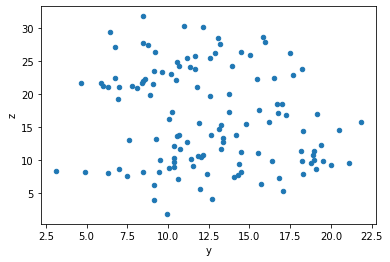

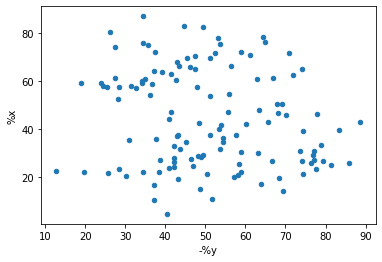

In [10]:
df_igle.plot.scatter(x='y',y='z')
df_igle.plot.scatter(x='-%y',y='%x')

<AxesSubplot:xlabel='-%y', ylabel='%x'>

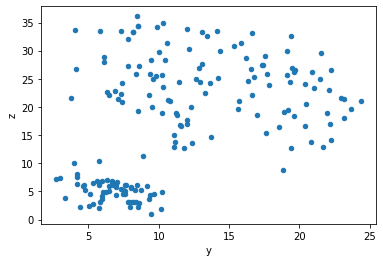

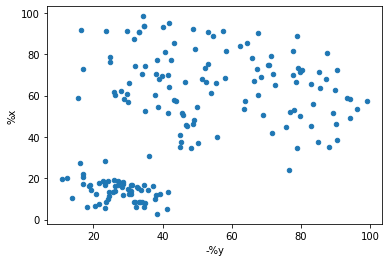

In [11]:
df_ima.plot.scatter(x='y',y='z')
df_ima.plot.scatter(x='-%y',y='%x')

<AxesSubplot:xlabel='-%y', ylabel='%x'>

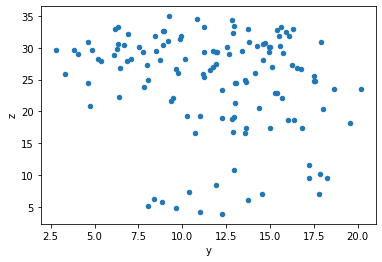

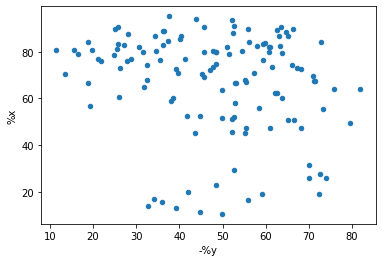

In [12]:
df_efferent.plot.scatter(x='y',y='z')
df_efferent.plot.scatter(x='-%y',y='%x')